## Small banking in Wisconsin
This notebook provides details on the figures and computations in the Center For Research on the Wisconsin Economy (CROWE) data brief \#1, "The Dodd-Frank Act and Small Bank Creation." You can find the brief at [crowe.wisc.edu/data-briefs](https://crowe.wisc.edu/data-briefs/)


### Files needed
* OFFICES2_ALL.CSV
* us-zip-code-latitude-and-longitude.csv
* ACS_16_5YR_S1901_with_ann.csv
* files in the folder: cb_2017_us_county_5m 

In [1]:
import pandas as pd                    # for data handling
import numpy as np                     # for numerical methods and data structures
import matplotlib.pyplot as plt        # for plotting
import geopandas                            # geopandas for maps work
from shapely.geometry import Point          # shapely handles the coordinate references for plotting shapes
import seaborn as sns                  # some new plot types, more automation


This data set from the FDIC contains basic information about every bank branch in the United States---mostly just location data. It does not have the balance-sheet type data available in the call reports. 

Keep only the Wisconsin branches. 

In [2]:
# Data are from https://www5.fdic.gov/idasp/warp_download_all.asp (5/9/2019)
banks = pd.read_csv('Offices2/OFFICES2_ALL.CSV', encoding='mbcs')
banks = banks[banks.STALP=='WI']


print(banks.info())
print(banks.head(2))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1990 entries, 7011 to 88548
Data columns (total 30 columns):
ADDRESS            1990 non-null object
BKCLASS            1990 non-null object
CBSA               1990 non-null object
CBSA_DIV           1990 non-null object
CBSA_DIV_FLG       1990 non-null int64
CBSA_DIV_NO        1990 non-null int64
CBSA_METRO         1990 non-null int64
CBSA_METRO_FLG     1990 non-null int64
CBSA_METRO_NAME    1990 non-null object
CBSA_MICRO_FLG     1990 non-null int64
CBSA_NO            1990 non-null int64
CERT               1990 non-null int64
CITY               1990 non-null object
COUNTY             1990 non-null object
CSA                1990 non-null object
CSA_FLG            1990 non-null int64
CSA_NO             1784 non-null float64
ESTYMD             1990 non-null object
FI_UNINUM          1990 non-null int64
MAINOFF            1990 non-null int64
NAME               1990 non-null object
OFFNAME            1990 non-null object
OFFNUM            

### Geocoding bank locations
The data have bank zip codes. To map the branch locations, I need longitude and latitude. The public data file from OpenDataSoft give the zip code centroid long-lat. We'll merge this into the bank data. That is enough detail for what we are after here.

In [3]:
# My lat-lon file doesn't have these zips. Replace them with nearby zips

banks.loc[banks.ZIP==54482, 'ZIP'] = 54481
banks.loc[banks.ZIP==53548, 'ZIP'] = 53547

# This is a Sheboygan zip that maps to the lake. Change it to another Sheyboygan zip.
banks.loc[banks.ZIP==53082, 'ZIP'] = 53081

In [4]:
# Data from https://public.opendatasoft.com/explore/dataset/us-zip-code-latitude-and-longitude/export/?refine.state=WI

coords = pd.read_csv('us-zip-code-latitude-and-longitude.csv', sep=';')
coords.head(2)

,Zip,City,State,Latitude,Longitude,Timezone,Daylight savings time flag,geopoint
0,53006,Brownsville,WI,43.623996,-88.510890,-6,1,"43.623996, -88.51089"
1,53009,Byron,WI,43.769830,-88.494357,-6,1,"43.76983, -88.494357"


In [5]:
banks = pd.merge(left=banks, right=coords[['Latitude','Longitude','Zip']], left_on='ZIP', right_on='Zip', how='left')
banks.head(3)

,ADDRESS,BKCLASS,CBSA,CBSA_DIV,CBSA_DIV_FLG,CBSA_DIV_NO,CBSA_METRO,CBSA_METRO_FLG,CBSA_METRO_NAME,CBSA_MICRO_FLG,...,RUNDATE,SERVTYPE,STALP,STCNTY,STNAME,UNINUM,ZIP,Latitude,Longitude,Zip
0,441 Main Avenue,N,"Green Bay, WI",,0,0,24580,1,"Green Bay, WI",0,...,2019-05-09,11,WI,55009,Wisconsin,8107,54115,44.420420,-88.07896,54115
1,200 South Adams Street,N,"Green Bay, WI",,0,0,24580,1,"Green Bay, WI",0,...,2019-05-09,11,WI,55009,Wisconsin,7843,54301,44.489059,-88.01674,54301
2,935 Pilgrim Way,N,"Green Bay, WI",,0,0,24580,1,"Green Bay, WI",0,...,2019-05-09,11,WI,55009,Wisconsin,226854,54304,44.499346,-88.06318,54304


Next, create a geopandas dataframe from the bank location data. 

In [6]:
banks['coord'] = list(zip(banks.Longitude, banks.Latitude))
banks['coord'] = banks['coord'].apply(Point)
geo_banks = geopandas.GeoDataFrame(banks, geometry='coord')
geo_banks.crs = {'init':'epsg:4269'}

### Big and small banks
I want to differentiate between small banks (assets < 10 bil. USD) and big banks (assets > 10 bil USD). The Fed publishes a list of banks with $10 bil. and greater in assets. I hand-coded a list of all the big banks that have branches in Wisconsin. I would prefer to have a file that has `FUI_UNINUM` for all these banks to get a clean merge, but I could not find one. I'm sure it is out there somewhere...

In [7]:
# This is a hand-coded list of big banks with branches in Wisconsin. The list of big banks is from
# www.ffiec.gov/nicpubweb/nicweb/HCSGreaterThan10B.aspx

# 2239 = Wells Fargo
# 417 = JP Morgan Chase
# 4383 = US Bank
# 4287 = PNC
# 10718 = BMO Harris
# 589 = Northern Trust
# 4390 = Huntington 
# 46854 = CIBC
# 76794 = Deere Financial
# 3561 = Associated bank
# 12139 = Webster
# 41164 = TCF
# 2492 = Old National
# 45375 = Flagstar
# 8180 = Bremer

big_list = [2239, 417, 4383, 4287, 10718, 
            589, 4390, 76794, 46854, 3561, 
            12139, 41164, 2492, 45375, 8180]

banks['big'] = 0
banks.loc[banks['FI_UNINUM'].isin(big_list), 'big'] = 1
banks.head(2)

,ADDRESS,BKCLASS,CBSA,CBSA_DIV,CBSA_DIV_FLG,CBSA_DIV_NO,CBSA_METRO,CBSA_METRO_FLG,CBSA_METRO_NAME,CBSA_MICRO_FLG,...,STALP,STCNTY,STNAME,UNINUM,ZIP,Latitude,Longitude,Zip,coord,big
0,441 Main Avenue,N,"Green Bay, WI",,0,0,24580,1,"Green Bay, WI",0,...,WI,55009,Wisconsin,8107,54115,44.420420,-88.07896,54115,POINT (-88.07896 44.42042),1
1,200 South Adams Street,N,"Green Bay, WI",,0,0,24580,1,"Green Bay, WI",0,...,WI,55009,Wisconsin,7843,54301,44.489059,-88.01674,54301,POINT (-88.01674 44.489059),1


### Shape files
Load Census shape files.  

In [8]:
# Data from 
# https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html

# states = geopandas.read_file('cb_2017_us_state_5m/cb_2017_us_state_5m.shp')
# states.head()

# WI's fips code is 55. Keep only those counties
counties = geopandas.read_file('cb_2017_us_county_5m/cb_2017_us_county_5m.shp')
counties = counties[counties['STATEFP']=='55']


Which counties in Wisconsin are rural? I am using the definition of a rural county from the USDA ERS. Again, this is hand coded. [Sometimes it's just quicker.](https://www.goodreads.com/quotes/21422-i-didn-t-have-time-to-write-a-short-letter-so) 

Rural definitions: https://www.ers.usda.gov/webdocs/DataFiles/53180/25603_WI.pdf?v=0

In [9]:
non_rural = ['Douglas',  'St. Croix', 'Pierce', 'Chippewa', 'Eau Claire', 'Marathon', 'Oconto', 
             'Brown', 'Kewaunee', 'Outagamie', 'Winnebago', 'Calumet', 'Fond du Lac', 'Sheboygan',
             'Washington', 'Ozaukee', 'Milwaukee', 'Waukesha', 'Racine', 'Kenosha', 'Rock',
             'Green', 'Dane', 'Columbia', 'Iowa']
counties['rural'] = 1
counties.loc[counties['NAME'].isin(non_rural), 'rural'] = 0
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,LSAD,ALAND,AWATER,geometry,rural
32,55,075,01581097,0500000US55075,55075,Marinette,06,3624558795,389917044,"POLYGON ((-88.42595 45.621453, -88.425302 45.7...",1
73,55,137,01581128,0500000US55137,55137,Waushara,06,1621695264,29151536,"POLYGON ((-89.59797999999999 44.245725, -89.34...",1
75,55,113,01581116,0500000US55113,55113,Sawyer,06,3256422227,240678258,"POLYGON ((-91.550951 46.04111, -91.551282 46.1...",1
152,55,135,01581127,0500000US55135,55135,Waupaca,06,1936513136,45278485,"POLYGON ((-89.22374499999999 44.681365, -88.90...",1
159,55,071,01581095,0500000US55071,55071,Manitowoc,06,1526268667,2343369333,"POLYGON ((-88.04324 44.241018, -87.923755 44.2...",1


### Change projections
The Census files are not in Mercator, so everyone thinks they looks funny when plotted. Let's change the projection to Mercator so that they look 'normal' when plotted.  

In [10]:
counties = counties.to_crs({'init': 'epsg:3395'})
geo_banks = geo_banks.to_crs({'init': 'epsg:3395'})

### Plot branch locations 

1. County shapes (which also give us the Wisconsin borders)
2. Big banks in blue, small banks in red
3. Shade rural counties grey

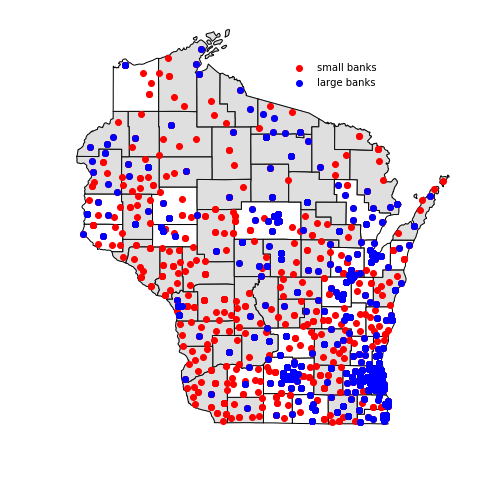

In [11]:
fig, gax = plt.subplots(figsize = (10,8))

# Plot the counties
counties.plot(ax = gax, edgecolor='black',color='white')
counties[counties['rural']==1].plot(ax = gax, edgecolor = 'black',color = 'grey', alpha = 0.25, label = 'rural')

# Plot the banks
geo_banks.plot(ax = gax, color='red', alpha = 1.0, label = 'small banks')
geo_banks[geo_banks['big']==1].plot(ax = gax, color='blue', alpha = 1.0, label = 'large banks')

gax.legend(frameon = False)
leg = gax.get_legend().set_bbox_to_anchor((0.6, 0.7, 0.2,0.2)) # position the legend

# I don't want the axis with long and lat
plt.axis('off')

fig.savefig('bank_locs.pdf', bbox_inches='tight')

plt.show()

### Add family income by county
The data are from the American Community Survey for 2016. Clean up the data a bit and keep just a few measures of income. The data came in as strings, so convert them to floats. 

In [12]:
df = pd.read_csv('ACS_16_5YR_S1901_with_ann.csv')
df = df.drop(['GEO.id', 'GEO.display-label'], axis=1)
df = df.drop(0, axis=0)
df = df.rename(columns={'HC02_EST_VC01':'fam_total', 'HC02_EST_VC02':'fam_less10k', 'HC02_EST_VC13':'fam_median', 
                       'HC03_EST_VC13' : 'marfam_median', 'HC03_EST_VC01':'marfam_total'})
df = df[['fam_total', 'fam_less10k', 'fam_median', 'GEO.id2', 'marfam_median', 'marfam_total' ]]

cols_to_convert = ['fam_less10k','fam_median', 'fam_total', 'marfam_median', 'marfam_total']
df[cols_to_convert] = df[cols_to_convert].astype(float)

print(df.info())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72 entries, 1 to 72
Data columns (total 6 columns):
fam_total        72 non-null float64
fam_less10k      72 non-null float64
fam_median       72 non-null float64
GEO.id2          72 non-null object
marfam_median    72 non-null float64
marfam_total     72 non-null float64
dtypes: float64(5), object(1)
memory usage: 3.9+ KB
None


,fam_total,fam_less10k,fam_median,GEO.id2,marfam_median,marfam_total
1,5083.0,2.0,51989.0,55001,57606.0,4270.0
2,3999.0,4.9,51315.0,55003,61398.0,2892.0


Now merge the income data into the counties DataFrame.

In [13]:
counties = pd.merge(left=counties, right=df, left_on='GEOID', right_on='GEO.id2', how='left')
counties.info()  # Wisconsin has 72 counties

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 72 entries, 0 to 71
Data columns (total 17 columns):
STATEFP          72 non-null object
COUNTYFP         72 non-null object
COUNTYNS         72 non-null object
AFFGEOID         72 non-null object
GEOID            72 non-null object
NAME             72 non-null object
LSAD             72 non-null object
ALAND            72 non-null int64
AWATER           72 non-null int64
geometry         72 non-null object
rural            72 non-null int64
fam_total        72 non-null float64
fam_less10k      72 non-null float64
fam_median       72 non-null float64
GEO.id2          72 non-null object
marfam_median    72 non-null float64
marfam_total     72 non-null float64
dtypes: float64(5), int64(3), object(9)
memory usage: 10.1+ KB


In [14]:
counties = counties.sort_values('fam_median')
counties = counties.set_index('NAME')
counties.head(2).append(counties.tail(2)) # Top and bottom of the income distribution of counties



,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,LSAD,ALAND,AWATER,geometry,rural,fam_total,fam_less10k,fam_median,GEO.id2,marfam_median,marfam_total
NAME,,,,,,,,,,,,,,,,
Menominee,55,078,01581099,0500000US55078,55078,06,926201674,19038372,POLYGON ((-9905451.412553374 5609833.692698693...,1,881.0,12.3,38486.0,55078,49821.0,475.0
Rusk,55,107,01581114,0500000US55107,55107,06,2366092049,44813688,POLYGON ((-10190218.91514656 5691903.331671834...,1,4084.0,5.1,48912.0,55107,54003.0,3201.0
Ozaukee,55,089,01581105,0500000US55089,55089,06,603471584,2287458200,POLYGON ((-9803160.823019361 5325215.027165745...,0,24884.0,1.9,94276.0,55089,103542.0,21048.0
Waukesha,55,133,01581126,0500000US55133,55133,06,1423675192,79851458,POLYGON ((-9856403.488312405 5285762.591419796...,0,108819.0,1.7,96409.0,55133,103861.0,93307.0


### Plot income by county
Use a chloropleth to get an idea of the geographic distribution of income. 

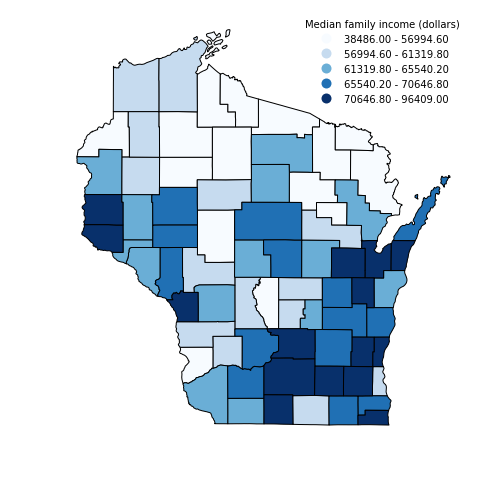

In [15]:
fig, gax = plt.subplots(1, 1, figsize = (10,8))

counties.plot(ax=gax, edgecolor='black', column='fam_median',  legend=True, cmap='Blues', scheme='quantiles')

gax.get_legend().set_title('Median family income (dollars)')
gax.get_legend().draw_frame(False)
gax.axis('off')

fig.savefig('income_map.pdf', bbox_inches='tight')

plt.show()

### Comparing income, rurality, and small bank shares
Here we create the share of total banks that are small in each county and merge the share data into the county data.

In [16]:
big_banks = banks[['COUNTY', 'big']].groupby('COUNTY').sum()       # count the entries with ones
all_banks = banks[['COUNTY', 'big']].groupby('COUNTY').count()     # count all the entries
all_banks = all_banks.rename(columns={'big':'all'})

In [17]:
counties = pd.merge(left=counties, right=big_banks, left_index = True, right_index=True, how='left')
counties = pd.merge(left=counties, right=all_banks, left_index = True, right_index=True, how='left')
counties.head() # Note that Menominee county has no banks

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,LSAD,ALAND,AWATER,geometry,rural,fam_total,fam_less10k,fam_median,GEO.id2,marfam_median,marfam_total,big,all
NAME,,,,,,,,,,,,,,,,,,
Menominee,55,078,01581099,0500000US55078,55078,06,926201674,19038372,POLYGON ((-9905451.412553374 5609833.692698693...,1,881.0,12.3,38486.0,55078,49821.0,475.0,NaN,NaN
Rusk,55,107,01581114,0500000US55107,55107,06,2366092049,44813688,POLYGON ((-10190218.91514656 5691903.331671834...,1,4084.0,5.1,48912.0,55107,54003.0,3201.0,1.0,7.0
Sawyer,55,113,01581116,0500000US55113,55113,06,3256422227,240678258,POLYGON ((-10191405.24695994 5756168.554360026...,1,4909.0,6.3,49879.0,55113,57803.0,3720.0,2.0,8.0
Ashland,55,003,01581061,0500000US55003,55003,06,2706535135,3230651989,(POLYGON ((-10070569.49817671 5911231.55107752...,1,3999.0,4.9,51315.0,55003,61398.0,2892.0,2.0,9.0
Vilas,55,125,01581122,0500000US55125,55125,06,2221447085,414426793,POLYGON ((-10023647.55357091 5746716.551447946...,1,6628.0,4.3,51476.0,55125,58936.0,5361.0,5.0,14.0


In [18]:
counties['small_share'] = (counties['all'] - counties['big']) / counties['all']

### Plot income against small bank importance by county

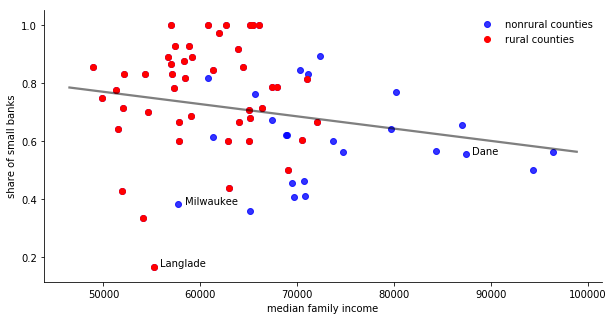

In [19]:
fig, my_ax = plt.subplots(figsize=(10,5)) 

# Theh seaborn regplot command. This is not called on an axis object (like in matplotlib)
# but we can pass it an axis so that we can do matplotlib-like tweaking.
sns.regplot(x='fam_median', y='small_share', data=counties,    # the data
            ax = my_ax,            # an axis object
            line_kws =  {'color':'black', 'alpha':0.5},
            scatter_kws = {'color':'blue'},                                  
            ci = 0, label='nonrural counties')                                               # confidence interval, 0 supresses it

temp = counties[counties['rural']==1]
my_ax.scatter(temp['fam_median'], temp['small_share'], color='red', label='rural counties')

sns.despine(ax = my_ax)    # a bit easier than matplotlib                         

# Our usual labeling 

my_ax.text(counties.loc['Milwaukee','fam_median']+700, counties.loc['Milwaukee','small_share'], 'Milwaukee')
my_ax.text(counties.loc['Dane','fam_median']+700, counties.loc['Dane','small_share'], 'Dane')
my_ax.text(counties.loc['Langlade','fam_median']+700, counties.loc['Langlade','small_share'], 'Langlade')

my_ax.set_ylabel('share of small banks')
my_ax.set_xlabel('median family income')

my_ax.legend(frameon=False)

fig.savefig('income_small.pdf', bbox_inches='tight')

plt.show()